In [65]:
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib as plt
import math

In [66]:
movements = pd.read_csv('../data/data_movements_1.csv')
trials = pd.read_csv('../data/data_trials_1.csv')
trials['trial'] = trials.trial - 1

In [67]:
df = movements[['x', 'y', 'time', 'trial', 'state']]

# Desired timestamp granularity
timestamp_granularity = 0.001

# Create an empty list to store interpolated dataframes
interpolated_dfs = []

# Iterate through the rows of the original DataFrame
for i in range(len(df) - 1):
    # Extract data from the current and next rows
    current_row = df.iloc[i]
    next_row = df.iloc[i + 1]

    # Calculate the time points for interpolation
    t1 = current_row["time"]
    t2 = next_row["time"]

    # Calculate the number of points to interpolate between t1 and t2
    num_points = int((t2 - t1) / timestamp_granularity)

    # Create an array of interpolated time points
    interpolated_times = np.linspace(t1, t2, num_points + 1)

    # Perform linear interpolation for 'x' and 'y' columns
    interpolated_x = np.interp(interpolated_times, [t1, t2], [current_row["x"], next_row["x"]])
    interpolated_y = np.interp(interpolated_times, [t1, t2], [current_row["y"], next_row["y"]])

    # Create a new DataFrame for this segment of interpolation
    interpolated_segment = pd.DataFrame({
        "x": interpolated_x,
        "y": interpolated_y,
        "time": interpolated_times,
        "trial": [current_row["trial"]] * (num_points + 1),  # Include trial number
        "state": [current_row["state"]] * (num_points + 1)  # Include state
    })

    # Append the interpolated segment to the list
    interpolated_dfs.append(interpolated_segment)

# Concatenate all interpolated segments into one DataFrame
interpolated_df = pd.concat(interpolated_dfs, ignore_index=True)

# Print the interpolated DataFrame
interpolated_df


,x,y,time,trial,state
0,-0.806695,11.226652,0.007613,0,search_ring
1,-0.806696,11.226649,0.008620,0,search_ring
2,-0.806696,11.226647,0.009626,0,search_ring
3,-0.806697,11.226644,0.010633,0,search_ring
4,-0.806698,11.226641,0.011640,0,search_ring
...,...,...,...,...,...
2296477,-0.621535,13.784077,2232.628675,299,iti
2296478,-0.621534,13.784071,2232.629676,299,iti
2296479,-0.621532,13.784065,2232.630678,299,iti
2296480,-0.621531,13.784060,2232.631679,299,iti


<Axes: xlabel='x', ylabel='y'>

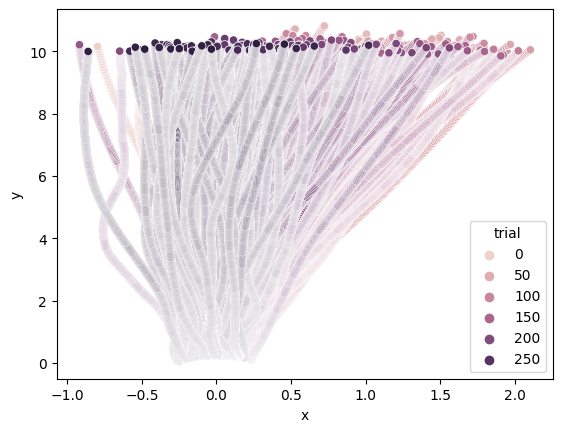

In [68]:
sns.scatterplot(data = interpolated_df.loc[interpolated_df.state == 'reach'], x = 'x', y = 'y', hue = 'trial')

In [69]:
# velocity is the change in distance over the change in time

def euclid_dist(x1, x2, y1, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)


change_in_dist= [0]
for i in range(1, len(interpolated_df)):
    current_row = interpolated_df.iloc[i]
    previous_row = interpolated_df.iloc[i-1]
    change_in_dist.append(euclid_dist(previous_row.x, current_row.x, previous_row.y, current_row.y))

interpolated_df['change_in_dist'] = change_in_dist



In [70]:
# velocity is the change in distance over the change in time
velocity = interpolated_df.change_in_dist/0.001
interpolated_df['velocity'] = velocity

In [71]:
max_vel_df = interpolated_df.loc[interpolated_df.state == 'reach'].groupby('trial').agg({'velocity': 'max'}).reset_index()
max_vel_df = max_vel_df.rename(columns={'velocity': 'max_vel'})
max_vel_df

,trial,max_vel
0,0,61.063630
1,1,50.371950
2,2,28.142171
3,3,38.619589
4,4,40.543999
...,...,...
295,295,18.152343
296,296,17.542370
297,297,27.249630
298,298,28.659589


In [72]:
joined = pd.merge(interpolated_df, max_vel_df, on = 'trial', how = 'left')

In [73]:
initial_vector = joined.loc[(joined.state == 'reach') & (joined.velocity == joined.max_vel)].copy()
min_time = initial_vector.groupby('trial').agg({'time':'min'}).reset_index().rename(columns={'time': 'min_time'})
initial_vector = pd.merge(initial_vector, min_time, on='trial', how='left')
initial_vector = initial_vector.loc[initial_vector.time == initial_vector.min_time]
initial_vector

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time
0,-0.272507,4.271797,5.184055,0,reach,0.061064,61.063630,61.063630,5.184055
1,0.197740,5.213415,16.346004,1,reach,0.050372,50.371950,50.371950,16.346004
17,-0.101955,4.380469,27.020663,2,reach,0.028142,28.142171,28.142171,27.020663
18,0.077412,4.096536,34.047415,3,reach,0.038620,38.619589,38.619589,34.047415
24,0.113032,4.180439,47.852966,4,reach,0.040544,40.543999,40.543999,47.852966
...,...,...,...,...,...,...,...,...,...
1359,-0.276832,4.472376,2204.851460,295,reach,0.018152,18.152343,18.152343,2204.851460
1361,-0.039009,4.138879,2211.151519,296,reach,0.017542,17.542370,17.542370,2211.151519
1365,0.076878,7.805813,2217.452733,297,reach,0.027250,27.249630,27.249630,2217.452733
1366,0.153403,6.332861,2223.968800,298,reach,0.028660,28.659589,28.659589,2223.968800


In [74]:
# convert x, y coordinates for 'reach' to polar and add these to the data as columns 
# function inspired from https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates 
def cart2pol(x, y):
    r = []
    theta = []
    for i in range(len(x)): 
        r.append(np.sqrt((x[i])**2 + (y[i])**2))
        theta.append(np.arctan2(y[i], x[i]))
    return(r, theta)


reach_x = initial_vector.x.values
reach_y  = initial_vector.y.values

r, theta = cart2pol(reach_x, reach_y)

initial_vector['r'] = r 
initial_vector['theta'] = theta

In [75]:
initial_vector

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time,r,theta
0,-0.272507,4.271797,5.184055,0,reach,0.061064,61.063630,61.063630,5.184055,4.280480,1.634502
1,0.197740,5.213415,16.346004,1,reach,0.050372,50.371950,50.371950,16.346004,5.217164,1.532885
17,-0.101955,4.380469,27.020663,2,reach,0.028142,28.142171,28.142171,27.020663,4.381655,1.594067
18,0.077412,4.096536,34.047415,3,reach,0.038620,38.619589,38.619589,34.047415,4.097268,1.551902
24,0.113032,4.180439,47.852966,4,reach,0.040544,40.543999,40.543999,47.852966,4.181967,1.543765
...,...,...,...,...,...,...,...,...,...,...,...
1359,-0.276832,4.472376,2204.851460,295,reach,0.018152,18.152343,18.152343,2204.851460,4.480935,1.632616
1361,-0.039009,4.138879,2211.151519,296,reach,0.017542,17.542370,17.542370,2211.151519,4.139062,1.580221
1365,0.076878,7.805813,2217.452733,297,reach,0.027250,27.249630,27.249630,2217.452733,7.806192,1.560948
1366,0.153403,6.332861,2223.968800,298,reach,0.028660,28.659589,28.659589,2223.968800,6.334718,1.546578


In [76]:
plot_data = pd.merge(initial_vector, trials, on = 'trial', how = 'left')

In [91]:
previous_uncertainty = ['baseline_no_uncertainty'] * 21
columns_to_iterate = ['cursor_vis', 'no_uncertainty', 'low_uncertainty', 'high_uncertainty', 'unlimited_uncertainty']

for i in range(21, len(plot_data) - 99):
    prev_row = plot_data.iloc[i - 1]
    if prev_row.no_uncertainty == True:
        previous_uncertainty.append('no_uncertainty')
    elif prev_row.low_uncertainty == True: 
        previous_uncertainty.append('low_uncertainty')
    elif prev_row.high_uncertainty == True: 
        previous_uncertainty.append('high_uncertainty')
    elif prev_row.unlimited_uncertainty == True: 
        previous_uncertainty.append('unlimited_uncertainty')
    else: 
        previous_uncertainty.append('unlimited_uncertainty')

previous_uncertainty += ['washout_unlimited_uncertainty'] * (300 - len(previous_uncertainty))
plot_data['previous_uncertainty'] = previous_uncertainty

In [92]:
plot_data

,x,y,time,trial,state,change_in_dist,velocity,max_vel,min_time,r,...,cycle,target_angle,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,endpoint_theta,movement_time,movement_initiation_time,previous_uncertainty
0,-0.272507,4.271797,5.184055,0,reach,0.061064,61.063630,61.063630,5.184055,4.280480,...,0,90,0.0,0.0,0.0,0.0,94.489680,0.232937,0.433169,baseline_no_uncertainty
1,0.197740,5.213415,16.346004,1,reach,0.050372,50.371950,50.371950,16.346004,5.217164,...,1,90,0.0,0.0,0.0,0.0,89.206933,0.264816,0.618340,baseline_no_uncertainty
2,-0.101955,4.380469,27.020663,2,reach,0.028142,28.142171,28.142171,27.020663,4.381655,...,2,90,0.0,0.0,0.0,0.0,88.307920,0.533958,0.683198,baseline_no_uncertainty
3,0.077412,4.096536,34.047415,3,reach,0.038620,38.619589,38.619589,34.047415,4.097268,...,3,90,0.0,0.0,0.0,0.0,88.960166,0.366962,0.500198,baseline_no_uncertainty
4,0.113032,4.180439,47.852966,4,reach,0.040544,40.543999,40.543999,47.852966,4.181967,...,4,90,0.0,0.0,0.0,0.0,91.315087,0.500493,0.317631,baseline_no_uncertainty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.276832,4.472376,2204.851460,295,reach,0.018152,18.152343,18.152343,2204.851460,4.480935,...,295,90,0.0,0.0,0.0,0.0,91.414960,0.783890,0.417202,washout_unlimited_uncertainty
296,-0.039009,4.138879,2211.151519,296,reach,0.017542,17.542370,17.542370,2211.151519,4.139062,...,296,90,0.0,0.0,0.0,0.0,90.192737,0.848779,0.368222,washout_unlimited_uncertainty
297,0.076878,7.805813,2217.452733,297,reach,0.027250,27.249630,27.249630,2217.452733,7.806192,...,297,90,0.0,0.0,0.0,0.0,88.503831,0.599805,0.400217,washout_unlimited_uncertainty
298,0.153403,6.332861,2223.968800,298,reach,0.028660,28.659589,28.659589,2223.968800,6.334718,...,298,90,0.0,0.0,0.0,0.0,87.450354,0.816836,0.465233,washout_unlimited_uncertainty


<Axes: xlabel='trial', ylabel='theta'>

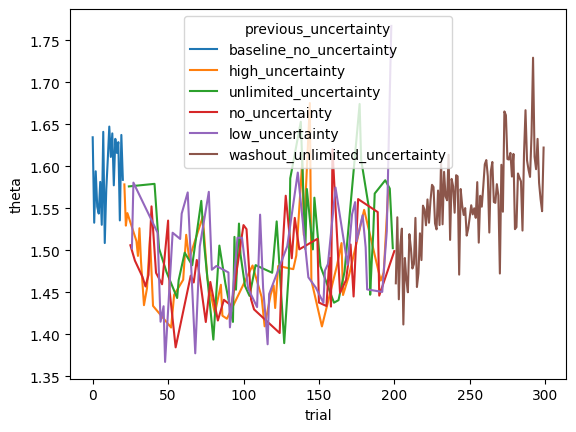

In [99]:
sns.lineplot(data = plot_data, x = 'trial', y = 'theta', hue = 'previous_uncertainty', sort=False)

154.6986046853223